# Introduction to MTLnet

Welcome! This jupyter notebook carries out core analyses and visualizations for exploring functional and structural network connectivity in the medial temporal lobe (MTL). We have provide a sample dataset, and our methods can be applied to your own datasets of healthy or diseased subjects. Input data includes time series from 7T resting state BOLD-fMRI as well as volumetric data derived from 7T T2-weighted MRI. Note: metrics derived from bootstrapped or permuted data may vary slightly each time the pipeline is run due to randomization inherent to the procedure.

This serves as a supplement to our paper in submission at Human Brain Mapping [link to be included upon publication of paper]. Please see paper for details on image acquisition, processing, and analysis.

MTL segmentation was carried out using the ASHS pipeline (https://sites.google.com/site/hipposubfields/) 

# 1. Setup

Here we import some key modules and define our MTL labels. We have defined 10 subregions per hemisphere as follows:

<strong>Hippocampal subfields: </strong> CA1, CA2, CA3, DG (dentate gyrus), SUB (subiculum), TAIL (posterior-most aspects of hippocampus)

<strong> Extra-hippocampal cortical regions </strong>: ERC (entorhinal cortex), PHC (parahippocampal cortex), BA35 and BA36 (Brodmann areas, part of the perirhinal corex)

*CA=cornu ammonis

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import bct
import ncat
import seaborn as sb
import itertools
import copy

from scipy.stats import linregress  
from tabulate import tabulate
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [
       r'\usepackage{sansmath}',
       r'\sansmath'
]

%matplotlib inline

sb.set(context="poster", font_scale=0.9)
mycmap=sb.cubehelix_palette(start=2.8,rot=0.05,as_cmap=True)

MTlabels = ['LCA1','LCA2','LDG', 'LCA3', 'LTAIL', 'LSUB', 'LERC','LBA35','LBA36','LPHC',
            'RCA1','RCA2','RDG', 'RCA3', 'RTAIL', 'RSUB', 'RERC', 'RBA35','RBA36','RPHC']
MTlabelshalf= ['CA1','CA2','DG', 'CA3', 'TAIL', 'SUB', 'ERC','BA35','BA36','PHC']
N=len(MTlabelshalf)

# 2. Function Definitions

Here we define key functions which will be used to generate the networks and carry out network analyses:

In [20]:
def null_rand(thismat):
    """
    generates a random matrix which preserves strength distribution by permuting entries in upper triangular matrix
    """
    
    dummy = np.triu(np.ones(np.shape(thismat)), 1) 
    full_upper = thismat[dummy == 1]
    ind = np.random.permutation(range(np.size(full_upper)))
    full_upper_perm= full_upper[ind]
    full_perm = dummy
    full_perm[dummy == 1] = full_upper_perm
    full_perm = full_perm + np.transpose(full_perm)
    return full_perm

def fisher(mymat):
    """
    fisher r to z transform on a matrix mymat
    """
    z = 0.5*np.log((1+mymat)/(1-mymat))
    return z

def makestructmat(structure):
    """
    generates structural covariance matrix given gray matter volumes in a group of subjects
    """
    structmat_tmp = np.corrcoef(structure)
    np.fill_diagonal(structmat_tmp, 0)
    structmat = fisher(structmat_tmp)     
    return structmat

def show_modules(mat, partitions, labels, colormap):
    """
    displays modular organization given a matrix and its partitions into modules
    """
    bounds, ixes = bct.grid_communities(np.array(map(int,partitions.T)))
    reorderedlabels = [ labels[i] for i in ixes]

    ax = sb.heatmap(mat[np.ix_(ixes,ixes)], square=True,xticklabels=reorderedlabels,
                                 yticklabels=reorderedlabels, cmap=colormap)
    for i in range(1,len(bounds)-1):

        ax.axvline(x=bounds[i]+0.5,color='red',ymin=1-(0.5+bounds[i-1])/(0.5+bounds[len(bounds)-1]),ymax=1-(0.5+bounds[i])/(0.5+bounds[len(bounds)-1]))
        ax.axvline(x=bounds[i]+0.5,color='red',ymin=1-(0.5+bounds[i])/(0.5+bounds[len(bounds)-1]),ymax=1-(0.5+bounds[i+1])/(0.5+bounds[len(bounds)-1]))
        ax.axhline(19.5-bounds[i],color='red',xmin=(0.5+bounds[i])/(0.5+bounds[len(bounds)-1]),xmax=(0.5+bounds[i+1])/(0.5+bounds[len(bounds)-1]))
        ax.axhline(19.5-bounds[i],color='red',xmin=(0.5+bounds[i-1])/(0.5+bounds[len(bounds)-1]),xmax=(0.5+bounds[i])/(0.5+bounds[len(bounds)-1]))

    ax.axvline(x=bounds[0]+0.5,color='red',ymin=1-(0.5+bounds[0])/(0.5+bounds[len(bounds)-1]),ymax=1-(0.5+bounds[1])/(0.5+bounds[len(bounds)-1]))
    ax.axhline(bounds[len(bounds)-1]-bounds[0],color='red',xmin=(0.5+bounds[0])/(0.5+bounds[len(bounds)-1]),xmax=(0.5+bounds[1])/(0.5+bounds[len(bounds)-1]))

    ax.axvline(x=bounds[len(bounds)-1]+0.5,color='red',ymin=1-(0.5+bounds[len(bounds)-2])/(0.5+bounds[len(bounds)-1]),ymax=1-(0.5+bounds[len(bounds)-1])/(0.5+bounds[len(bounds)-1]))
    ax.axhline(bounds[len(bounds)-1]-bounds[len(bounds)-1],color='red',xmin=(0.5+bounds[len(bounds)-2])/(0.5+bounds[len(bounds)-1]),xmax=(0.5+bounds[len(bounds)-1])/(0.5+bounds[len(bounds)-1]))

def sig_mods(nperms, mymat, Q, gamma):
    """
    determines sigificance of modular organization using permutation testing
    """
    Q_null = np.zeros((nperms))
    for i in range(0, nperms):
        nullmat = null_rand(mymat)
        S_null, Q_null[i] = bct.community_louvain(nullmat,gamma)
    p = np.sum(Q_null > Q) / float(nperms)
    return p

def struct_bootmats(structure, nboots):
    """
    generates bootstrapped structural matrices
    """
    nsubs = np.shape(structure)[1]   
    nROIs = np.shape(structure)[0]     
    boot_structmats = np.zeros((nROIs,nROIs,nboots)) 
    for i in range(0, nboots):
        boot_idx = np.random.randint(0,nsubs, nsubs)
        boot_structure = structure[0:nROIs,boot_idx]
        boot_structmat = makestructmat(boot_structure)
        boot_structmat[boot_structmat < 0] = 0
        boot_structmats[:,:,i] = boot_structmat  
    return boot_structmats

def func_bootmats(funcmats, nboots):    
    """
    generates bootstrapped functional matrices
    """   
    nsubs = np.shape(funcmats)[2]  
    nROIs = np.shape(funcmats)[0] 
    boot_funcmats = np.zeros((nROIs,nROIs,nboots))    
    for i in range(0, nboots):
        boot_idx = np.random.randint(0,nsubs, nsubs)
        boot_funcmats[:,:,i] = np.mean(funcmats[:,:,boot_idx],axis=2)   
    return boot_funcmats

def binarize_mats(mymats, d):
    """
    generates binarized versions of a set of NxNxm matrices, with density d
    """ 
    m = np.size(mymats,2)
    bin_mats = np.zeros(np.shape(mymats))
    for i in range(m):
        bin_mats[:,:, i] =  bct.binarize(bct.threshold_proportional(mymats[:,:,i], d, copy=True), copy=True)
    return bin_mats

def nodal_efficiency(mymat):
    """
    generates nodal efficiency based on equation in Achard & Bullmore, PLoS Comp Bio 2007
    """
    L =  bct.weight_conversion(mymat, 'lengths', copy=True)
    D,B = bct.distance_wei(L) 
    np.fill_diagonal(D, 1)
    invD = 1.0/D
    Li = np.sum(invD,axis=0)/(np.shape(D)[1] - 1) 
    return Li

def nodal_efficiency_bin(mymat):
    """
    generates BINARY nodal efficiency based on equation in Achard & Bullmore, PLoS Comp Bio 2007
    """
    D = bct.distance_bin(mymat)
    np.fill_diagonal(D, 1)
    invD = 1.0/D
    Li = np.sum(invD,axis=0)/(np.shape(D)[1] - 1) 
    return Li

def boot_metrics(boot_mats, metric):   
    """
    generates global and local network metrics from bootstrapped networks
    accepted metrics are "CS" (strength), "CC" (clustering coeff), or "LE" (efficiency)
    one can add additional metrics to this function as desired
    """
    nboots = np.shape(boot_mats)[2] 
    nROIs = np.shape(boot_mats)[0] 
    boot_metric_global = np.zeros((nboots))
    boot_metric_local = np.zeros((nboots, nROIs))
    
    if metric=="CS":
        for i in range(0, nboots):
            boot_metric_local[i,:] = bct.strengths_und(boot_mats[:,:,i])/float(nROIs)
            boot_metric_global[i] = np.mean(bct.strengths_und(boot_mats[:,:,i]))

    elif metric=="CC":
        for i in range(0, nboots):
            boot_metric_local[i,:] = bct.clustering_coef_wu(boot_mats[:,:,i])
            boot_metric_global[i] = np.mean(bct.clustering_coef_wu(boot_mats[:,:,i]))

    elif metric=="LE":
        for i in range(0, nboots):
            boot_metric_local[i,:] = nodal_efficiency(boot_mats[:,:,i])
            boot_metric_global[i] = bct.efficiency_wei(boot_mats[:,:,i])
    else:
        print "incorrect metric input - must be CS, CC, or LE"
  
    return boot_metric_global,boot_metric_local

def boot_metrics_bin(boot_mats, metric):   
    """
    BINARY VERSION! generates global and local network metrics from bootstrapped networks
    accepted metrics are "CS" (strength), "CC" (clustering coeff), or "LE" (efficiency)
    one can add additional metrics to this function as desired
    """
    nboots = np.shape(boot_mats)[2] 
    nROIs = np.shape(boot_mats)[0] 
    
    boot_metric_local = np.zeros((nboots, nROIs))
    boot_metric_local_rand = np.zeros((nboots,nROIs))
    for i in range(0, nboots):
        randix = np.random.permutation(nROIs)
        if metric=="CS":   
            boot_metric_local[i,:] = bct.degrees_und(boot_mats[:,:,i])/float(nROIs)   
            boot_metric_local_rand[i,:] = boot_metric_local[i,randix]    
        elif metric=="CC":     
            boot_metric_local[i,:] = bct.clustering_coef_bu(boot_mats[:,:,i])    
            boot_metric_local_rand[i,:] = boot_metric_local[i,randix]
        elif metric=="LE":     
            boot_metric_local[i,:] = nodal_efficiency_bin(boot_mats[:,:,i])
            boot_metric_local_rand[i,:] = boot_metric_local[i,randix]
        else:
            print "incorrect metric input - must be CS, CC, or LE" 
    return boot_metric_local, boot_metric_local_rand

def asymm(L,R):
    """
    returns asymmetry index as (R-L)/(R+L)  
    """    
    AI = np.divide(R-L,R+L)
    AI = np.nan_to_num(AI) 
    return AI

def dice(mat1, mat2):
    """
    Computes the Dice Similarity Coefficient
    
    """
    mat1 = np.asarray(mat1).astype(np.bool)
    mat2 = np.asarray(mat2).astype(np.bool)
    if mat1.shape != mat2.shape:
        raise ValueError("mat1 and mat2 should be same size.")    
    intersection = np.logical_and(mat1, mat2)
    return 2. * intersection.sum() / (mat1.sum() + mat2.sum())

# 3. Structural Network Generation

Here we generate the group-level structural covariance network from a group of 31 healthy subjects:

In [3]:
# Grab volumes from csv file
fname="../data/structural/all_volumes.csv"
structure = np.matrix(np.loadtxt(fname,delimiter=','))
volumes = copy.deepcopy(structure)

# Normalize volumes by A-P extent in cortical regions
fname_extent = "../data/structural/all_extents.csv"
extent= np.matrix(np.loadtxt(fname_extent,delimiter=','))
ind_cortical = [6,7,8,9,16,17,18,19] # indices of cortical regions (bilateral ERC,BA35,BA36,PHC) to normalize by extent
structure[ind_cortical,:] = np.divide(structure[ind_cortical,:],extent[ind_cortical,:])

# Extract ICV (intracranial volume) data
fname_ICV = "../data/structural/all_ICV.csv"
ICV = np.matrix(np.loadtxt(fname_ICV,delimiter=','))

# Regress out ICV
slope = np.zeros((2*N))
for i in range(0, 2*N):
    slope[i], intercept, r_value, p_value, std_err = linregress(ICV,structure[i,:])
    structure[i,:] = structure[i,:] -slope[i]*(ICV -np.mean(ICV,axis=1))
structure = np.matrix(structure[0:2*N,:])

# Make structural matrix and threshold out negatives
structmat = makestructmat(structure)
structmat_nonzeroed = np.array(structmat)
structmat[structmat < 0] = 0

Let's plot the resulting adjacency matrix to visualize the resulting structural covariance network:

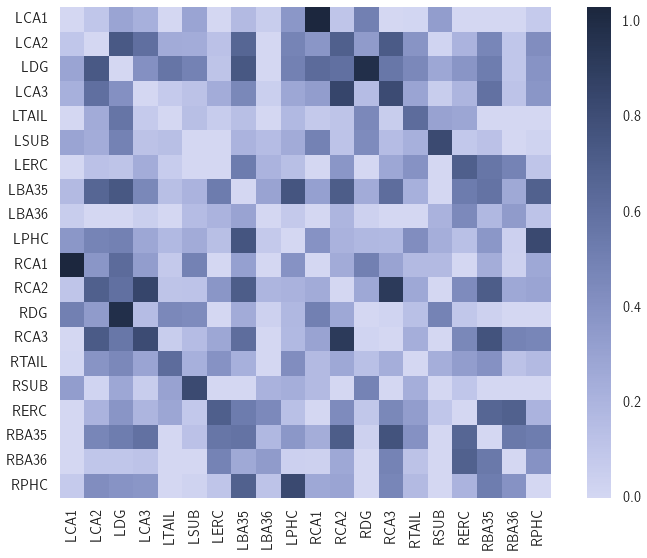

In [4]:
sb.heatmap(structmat, square=True,xticklabels=MTlabels, yticklabels=MTlabels, cmap=mycmap)

# 4. Functional Network Generation

Here we generate the group-level functional connectivity network from a group of 24 healthy subjects:

In [5]:
subject_names = ["S1", "S2","S3","S4","S5","S6","S7","S8","S9","S10", "S11","S12","S13", "S14", "S15", "S16","S17",
                 "S18","S19","S20","S21","S22","S23","S24"]


# Grab low-frequency rs-fmri time series from txt files
funcmats = np.zeros((len(MTlabels),len(MTlabels),len(subject_names)))
num_cols = 302
for idx, subject_name in enumerate(subject_names):
    
    # Left hemisphere    
    fname_L = "../data/functional/" + subject_name + "/res_tcourse_L.txt"
    with open(fname_L, 'r') as f:
        f.readline()
        f.seek(0)   
    Left_tcourse =np.matrix(np.loadtxt(fname_L, skiprows=1, usecols=range(1,num_cols)))  
    
    # Right hemisphere
    fname_R = "../data/functional/" + subject_name + "/res_tcourse_R.txt"
    with open(fname_R, 'r') as f:
        f.readline()
        f.seek(0)
    Right_tcourse = np.matrix(np.loadtxt(fname_R, skiprows=1, usecols=range(1,num_cols)))
     
    # Make functional matrix
    Bilat_tcourse = np.concatenate((Left_tcourse, Right_tcourse), axis=0)
    Bilat_tcourse = np.delete(Bilat_tcourse, [0,5,7,13,18,20],0) # exclude useless nodes (background, head, and miscellaneous labels)  
    mat = np.corrcoef(Bilat_tcourse)   
    np.fill_diagonal(mat, 0)    
    mat = fisher(mat) 
    funcmats[:,:,idx] = mat    

# Threshold out negatives and get group-level functional matrix
funcmats_nonzeroed = np.array(funcmats)
funcmats_nonzeroed_avg = np.mean(funcmats_nonzeroed,axis=2)
funcmats[funcmats < 0] =0
funcmat = np.mean(funcmats,axis=2)

Let's plot the resulting adjacency matrix to visualize the resulting functional connectivity network:

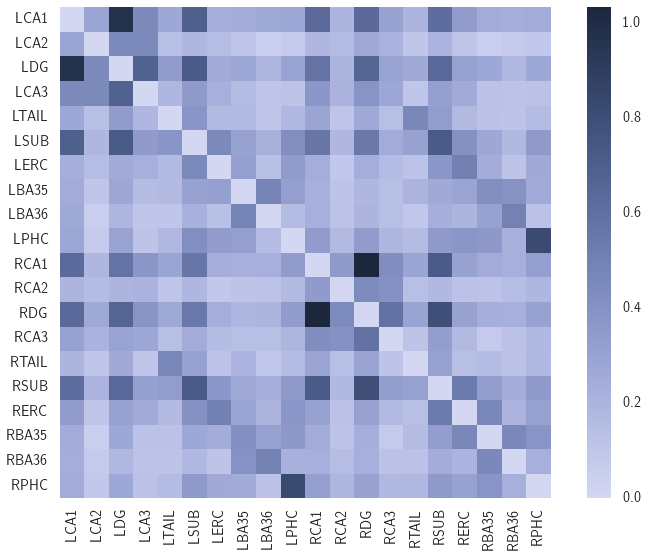

In [6]:
sb.heatmap(funcmat, square=True,xticklabels=MTlabels,yticklabels=MTlabels, cmap=mycmap)

# 5. Volumetric Analysis

Here, we compute and print out the volumes of each MTL subregion, as well as the whole hippocampus and whole MTL:

In [7]:
MTlabelshalf_plus= ['CA1','CA2','DG', 'CA3', 'TAIL', 'SUB', 'ERC','BA35','BA36','PHC','HIPP','MTL']
reordered = [0,1,3,2,4,5,6,7,8,9,10,11] #reorder subregions so it plots and prints table in a nice order

# Compute volumes:
volumes_plus = np.concatenate((volumes[0:N,:],np.sum(volumes[0:6,:],axis=0),
                                   np.sum(volumes[0:N,:],axis=0), volumes[N:2*N,:],
                                   np.sum(volumes[N:N+6,:],axis=0), np.sum(volumes[N:2*N,:],axis=0)),axis=0)
meanvols_plus = np.mean(volumes_plus,axis=1)
stdvols_plus = np.std(volumes_plus,axis=1)

N_plus=N+2
# Output volume table:
meanvol_lr_plus = np.reshape(meanvols_plus, (N_plus, 2),order='F')
stdvol_lr_plus = np.reshape(stdvols_plus, (N_plus, 2),order='F')
voldata = np.array(np.concatenate((meanvol_lr_plus[:,0], stdvol_lr_plus[:,0], meanvol_lr_plus[:,1], stdvol_lr_plus[:,1]),axis=1)) 
voltable = voldata[reordered,:].tolist()
MTlabelshalf_reordered = [ MTlabelshalf_plus[i] for i in reordered ]
for i,row in enumerate(voltable):
    row.insert(0,MTlabelshalf_reordered[i])
header = ["Subregion", "L Vol Mean","L Vol SD","R Vol Mean","R Vol SD"]
print tabulate(voltable, header, tablefmt="fancy_grid",floatfmt=".4g")

╒═════════════╤══════════════╤════════════╤══════════════╤════════════╕
│ Subregion   │   L Vol Mean │   L Vol SD │   R Vol Mean │   R Vol SD │
╞═════════════╪══════════════╪════════════╪══════════════╪════════════╡
│ CA1         │       820.7  │    182.4   │       803.5  │     160    │
├─────────────┼──────────────┼────────────┼──────────────┼────────────┤
│ CA2         │        26.21 │      8.692 │        30.38 │      11.28 │
├─────────────┼──────────────┼────────────┼──────────────┼────────────┤
│ CA3         │       107.1  │     18.69  │        88.86 │      26.31 │
├─────────────┼──────────────┼────────────┼──────────────┼────────────┤
│ DG          │       622.7  │    122.7   │       740.2  │     127.6  │
├─────────────┼──────────────┼────────────┼──────────────┼────────────┤
│ TAIL        │       315.4  │     83.03  │       296    │      69.92 │
├─────────────┼──────────────┼────────────┼──────────────┼────────────┤
│ SUB         │       837.2  │     93.25  │       853.2  │      

Here, we visualize the subregion-level volumetric asymmetry:

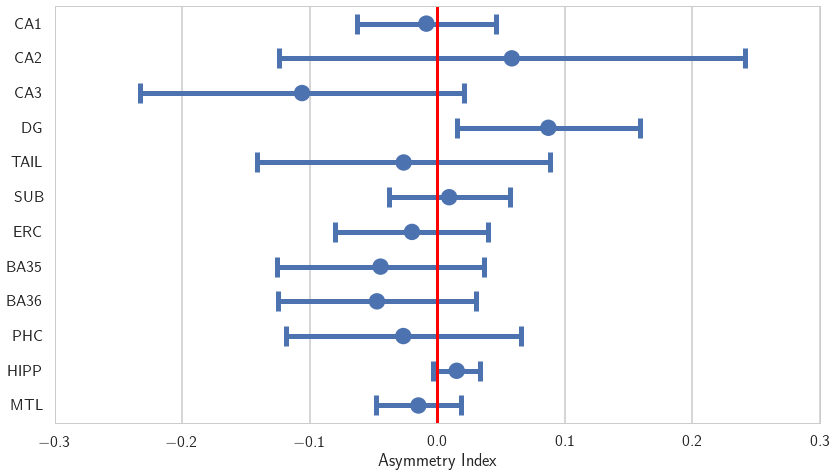

In [8]:
# Compute asymmetries (R- L / R + L):
asymmet= (volumes_plus[N_plus:2*N_plus,:] - volumes_plus[0:N_plus,:]) / (volumes_plus[N_plus:2*N_plus,:]+ volumes_plus[0:N_plus,:])
mean_asymm = np.mean(asymmet,axis=1)
std_asymm = np.std(asymmet,axis=1)

sb.set(context="poster", font_scale=1)
plt.figure(figsize=(12,7))
ts1=asymmet[reordered,:]
ts2=[ MTlabelshalf_plus[i] for i in reordered ]
df = pd.DataFrame(data=ts1,index=ts2)
sb.set_style("white",rc={'axes.linewidth': 0.5, 'axes.grid': False})
sb.set_style("whitegrid")
ax = sb.pointplot(data=df.transpose(),orient="h",ci=None,join=False)
plt.errorbar(np.array(mean_asymm[reordered]), [0,1,2,3,4,5,6,7,8,9,10,11], xerr=np.array(std_asymm[reordered]), linewidth=5, fmt="none",capsize=10,capthick=5)
ax.axvline(linewidth=3, color='r')
plt.xlabel('Asymmetry Index')
plt.tight_layout()

# 6. Weighted Network Analysis

Now, we carry out network analyses on the structural and functional networks:

## 6.1 Network Hubness and Asymmetry

First, let's compute several key network metrics - namely connectivity strength, clustering coefficient, and local efficiency - for both structural and functional networks, using bootstrapping to obtain a measure of variability in the data. 

Note: this may take a while. To speed things up, decrease the number of bootstrapped samples (nboots).

In [9]:
nboots = 1000

In [10]:
# Structural Network Analyses
boot_structmats = struct_bootmats(structure, nboots)
CS_global, CS_local =boot_metrics(boot_structmats, "CS")
CC_global, CC_local =boot_metrics(boot_structmats, "CC")
LE_global, LE_local =boot_metrics(boot_structmats, "LE")

In [11]:
# Functional Network Analyses
boot_funcmats =func_bootmats(funcmats, nboots)
CS_globalf, CS_localf =boot_metrics(boot_funcmats, "CS")
CC_globalf, CC_localf =boot_metrics(boot_funcmats, "CC")
LE_globalf, LE_localf =boot_metrics(boot_funcmats, "LE")

Now, let's visualize the results. We can do this in two ways. First, let's plot the subregion-level metrics, along with asymmetries, for structural and functional networks. This is shown in 6.1.1 below

### 6.1.1 Structural and Functional  Network Subregion Metrics

In [12]:
local_mets = [[CS_localf,CC_localf, LE_localf],[CS_local,CC_local, LE_local]]
titles = ["FUNCTIONAL","STRUCTURAL"]
metrics = ["Strength","Clust.","Eff."]

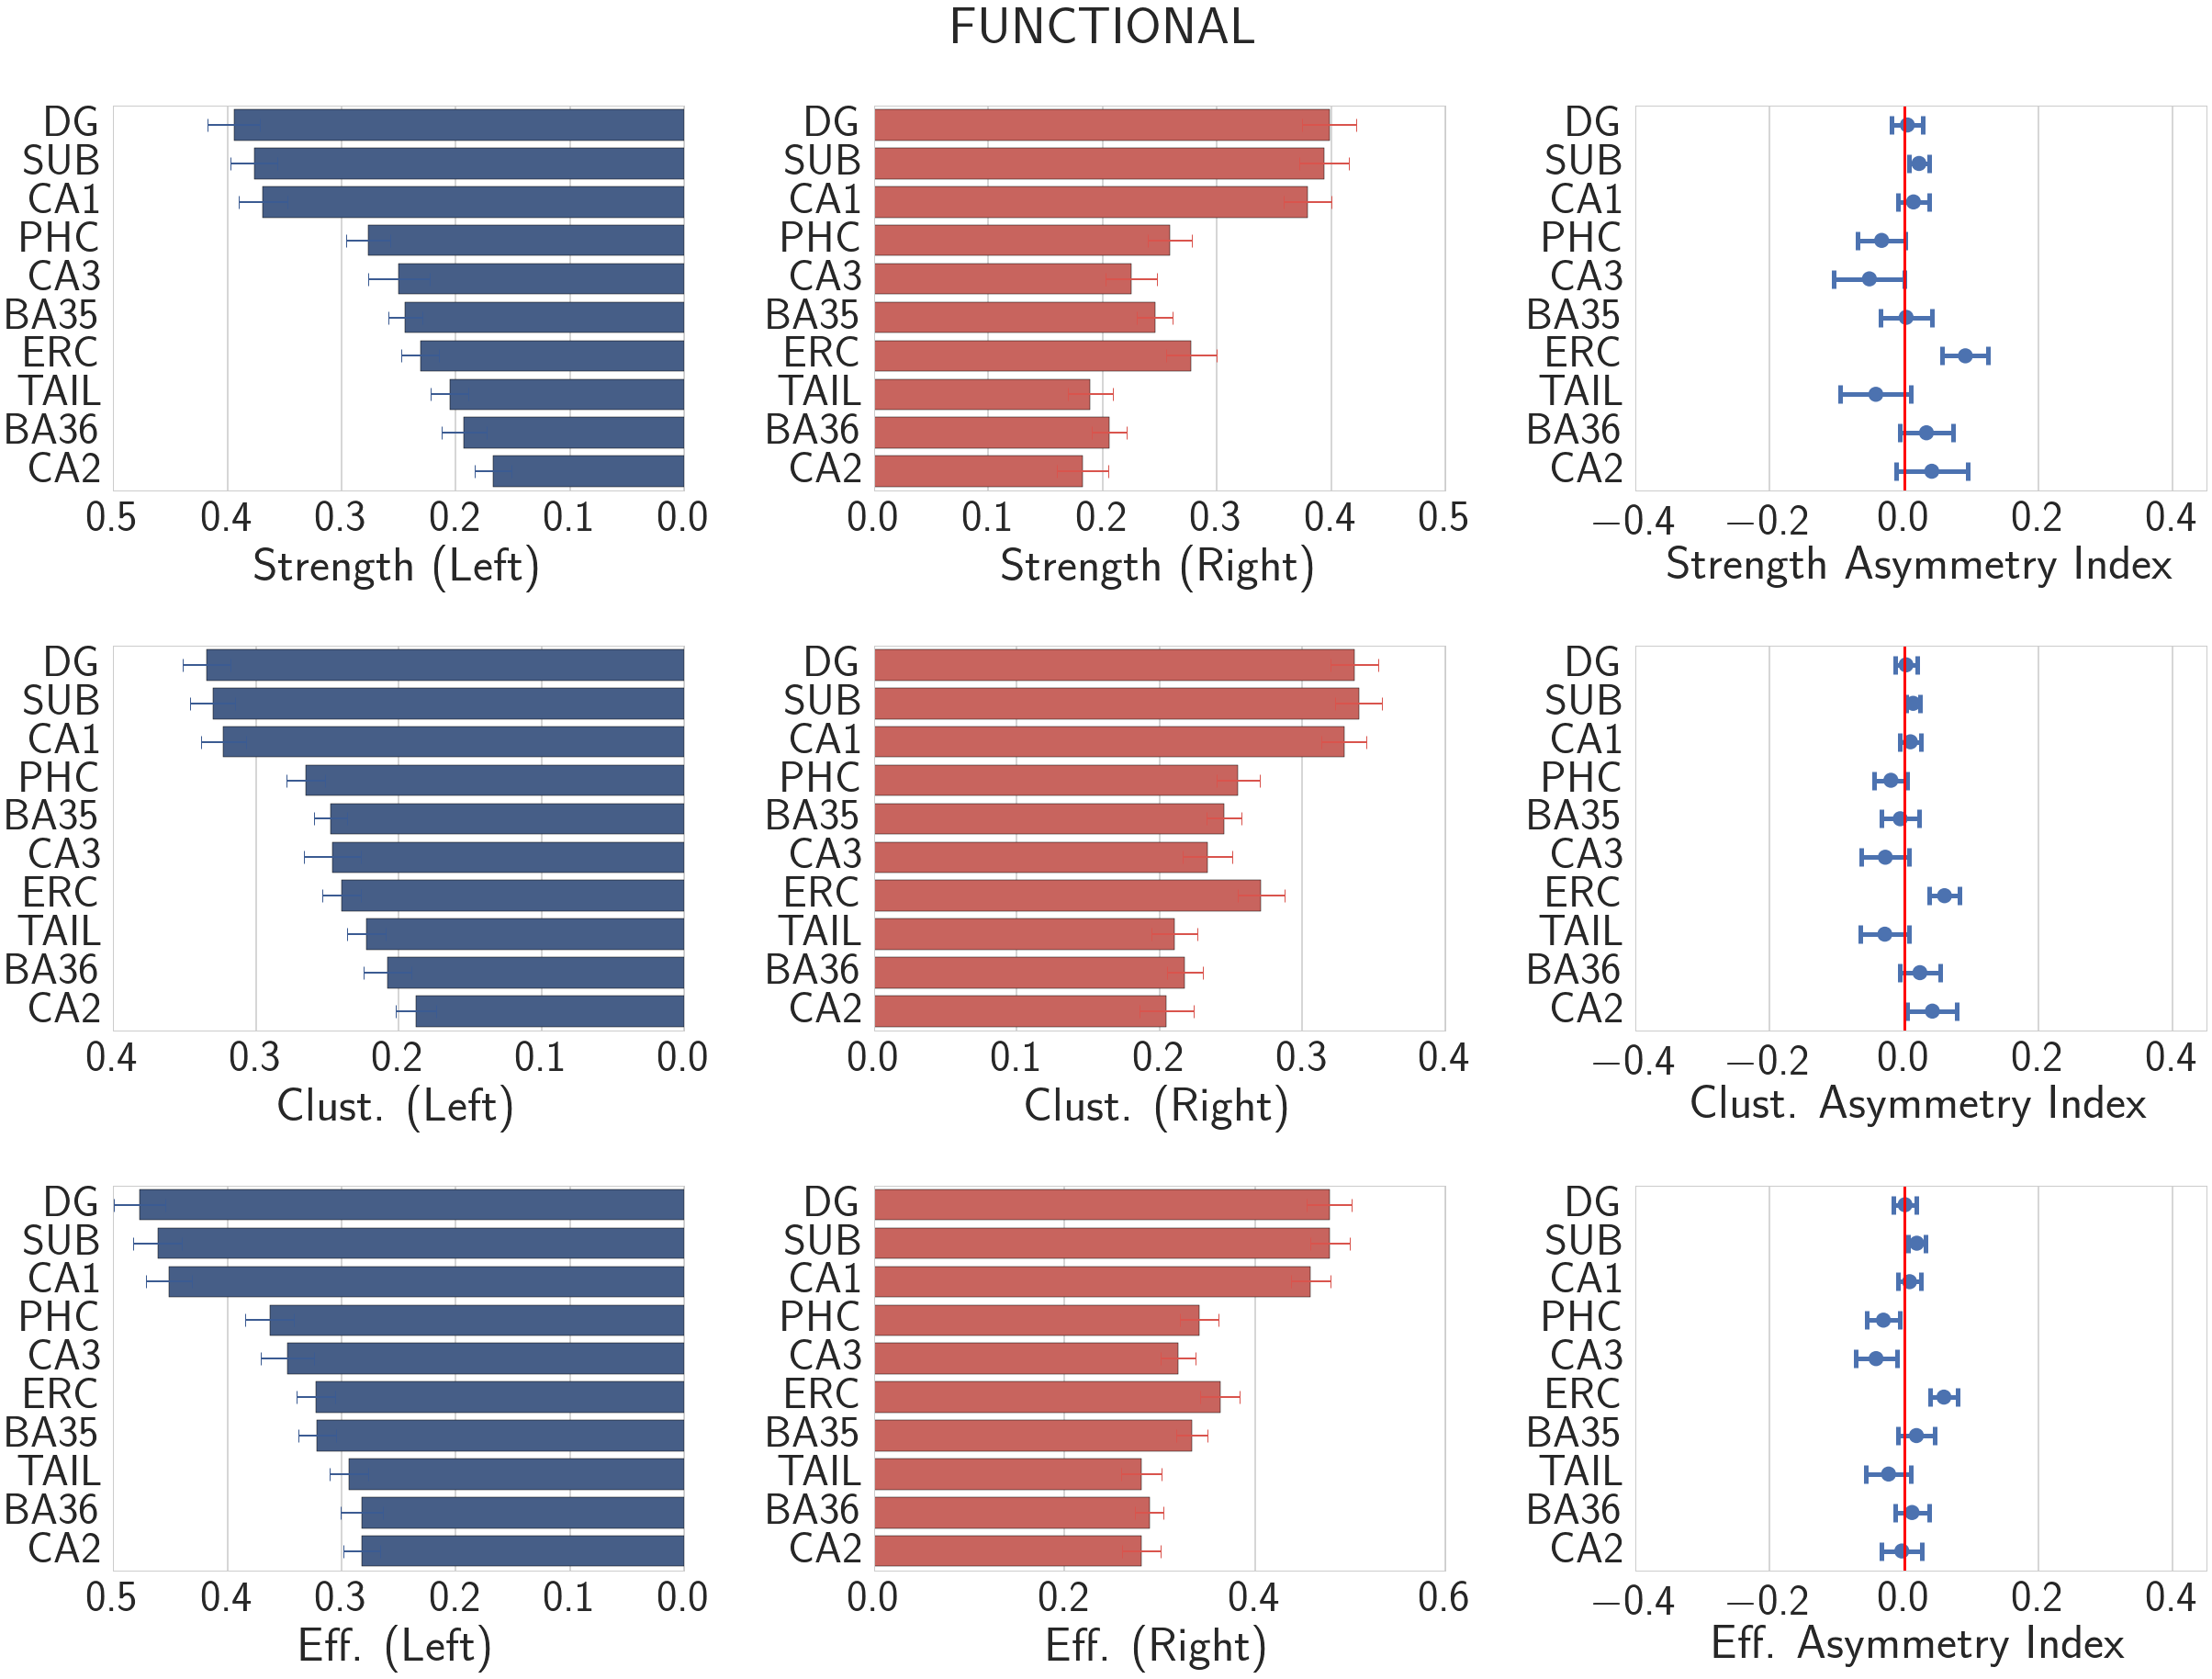

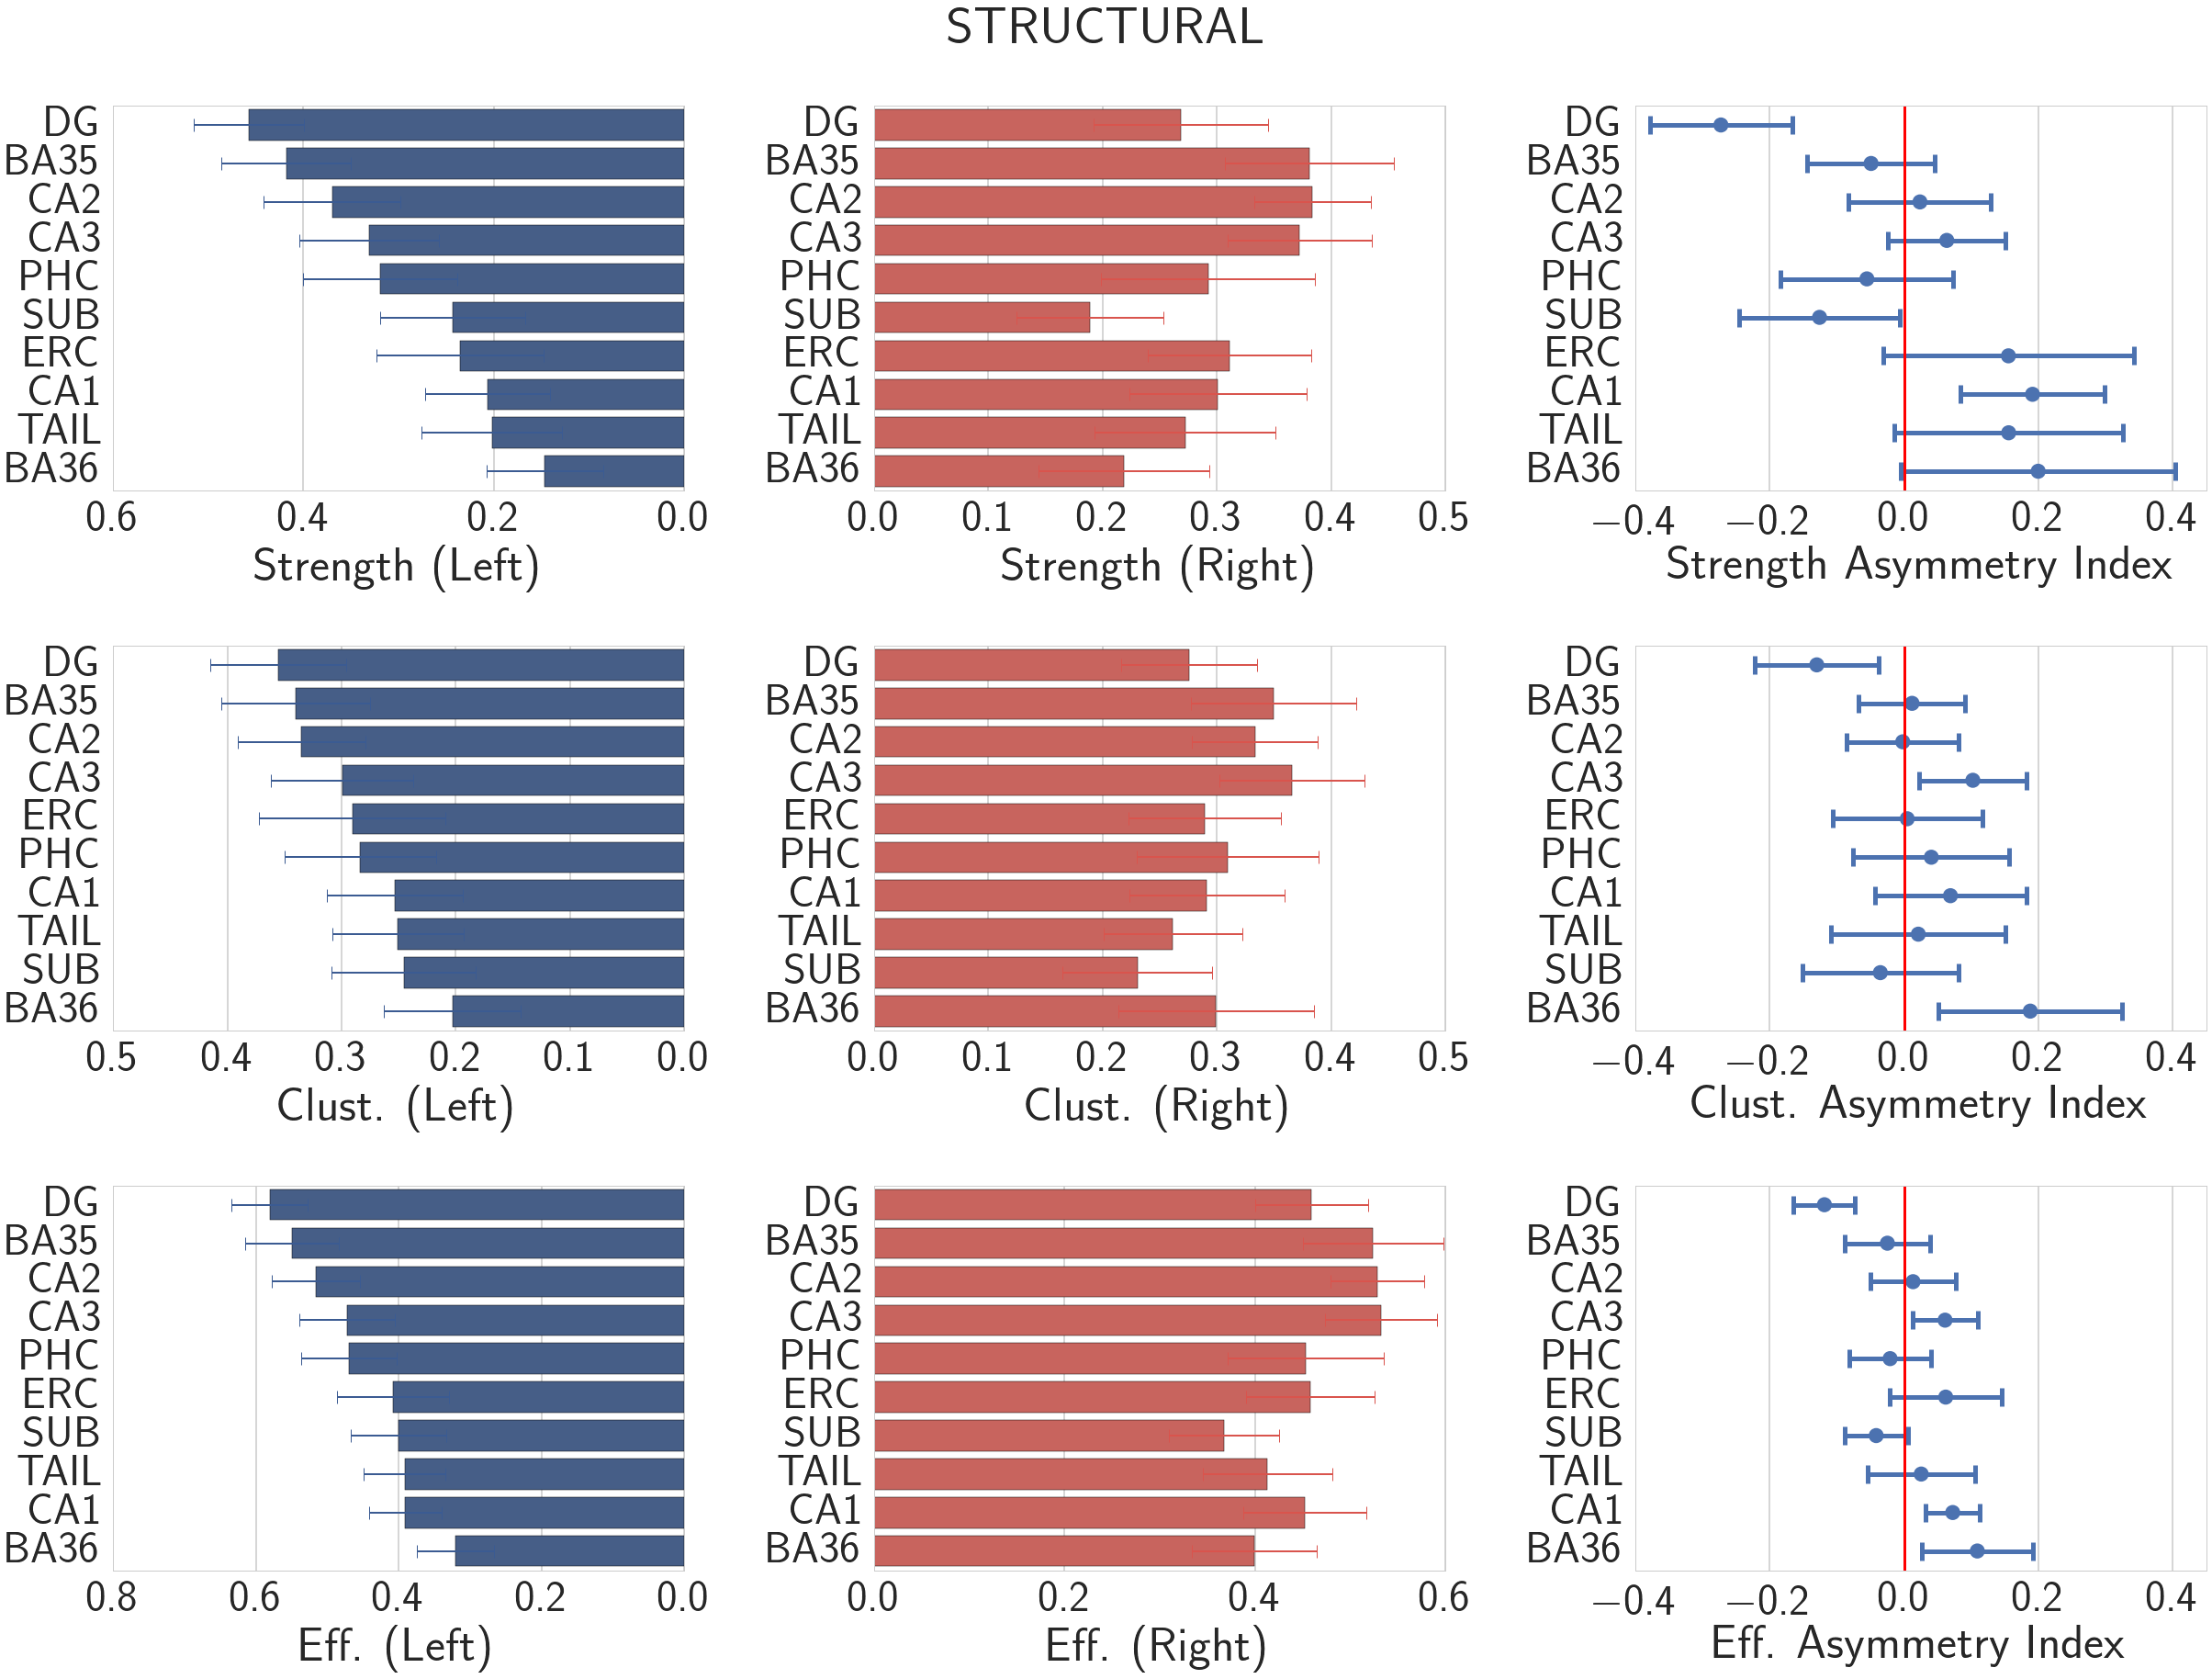

In [13]:
sb.set(context="poster", font_scale=3)
sb.set_style("whitegrid")

for i in range(2):
    plt.figure(figsize=(35,50))
    plt.suptitle(titles[i])
    for j in range(3):
        # Left CS
        left_met_sortidx = np.argsort(np.mean(local_mets[i][j][:,0:N],axis=0))[::-1]
        left_sorted = local_mets[i][j][:,left_met_sortidx]
        left_labels=[MTlabelshalf[k] for k in left_met_sortidx]
        
        plt.subplot(6, 3, 1 + 3*j)
        plt.locator_params(nbins=5)
        df = pd.DataFrame(data=left_sorted.transpose(),index=left_labels)
        plt.errorbar(np.array(np.mean(left_sorted,axis=0)),  np.arange(N), xerr=np.array(np.std(left_sorted,axis=0)), linewidth=2, fmt="none",capsize=7,capthick=1,ecolor=sb.xkcd_rgb["denim blue"]) 
        ax = sb.barplot(data=df.transpose(),ci=None,color=sb.xkcd_rgb["denim blue"],alpha=1,orient="h" )
        plt.gca().invert_xaxis()
        plt.xlabel(metrics[j] + ' (Left)')

        #Right CS
        right_sorted = local_mets[i][j][:,left_met_sortidx+N]
        right_labels=[MTlabelshalf[k] for k in left_met_sortidx]
        plt.subplot(6, 3, 2 + 3*j )
        plt.locator_params(nbins=5)
        df = pd.DataFrame(data=right_sorted.transpose(),index=right_labels)
        plt.errorbar(np.array(np.mean(right_sorted,axis=0)),np.arange(N), xerr=np.array(np.std(right_sorted,axis=0)), linewidth=2, fmt="none",capsize=7,capthick=1,ecolor=sb.xkcd_rgb["pale red"]) 
        ax = sb.barplot(data=df.transpose(),ci=None,color=sb.xkcd_rgb["pale red"],alpha=1,orient="h")
        plt.xlabel(metrics[j] + ' (Right)')

        # CS Asymmetry
        CS_asymm = (right_sorted - left_sorted)/(right_sorted + left_sorted)
        plt.subplot(6, 3, 3 + 3*j)
        plt.locator_params(nbins=5)
        df = pd.DataFrame(data=CS_asymm.transpose(),index=right_labels)
        ax = sb.pointplot(data=df.transpose(),orient="h",ci=None,join=False)
        plt.errorbar(np.array(np.mean(CS_asymm,axis=0)), np.arange(N), xerr=np.array(np.std(CS_asymm,axis=0)), linewidth=5, fmt="none",capsize=10,capthick=5)
        ax.axvline(linewidth=3, color='r')
        ax.set_xlim([-.4,.45])
        plt.xlabel(metrics[j] + ' Asymmetry Index')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
   
    #plt.show()

We can also plot the left vs right metrics along with the pearson correlation line and the unity line to visualize network symmetry. This also allows us to easily spot network hubs:

### 6.1.2 Structural and Functional Network Asymmetry and Hubness Visualization

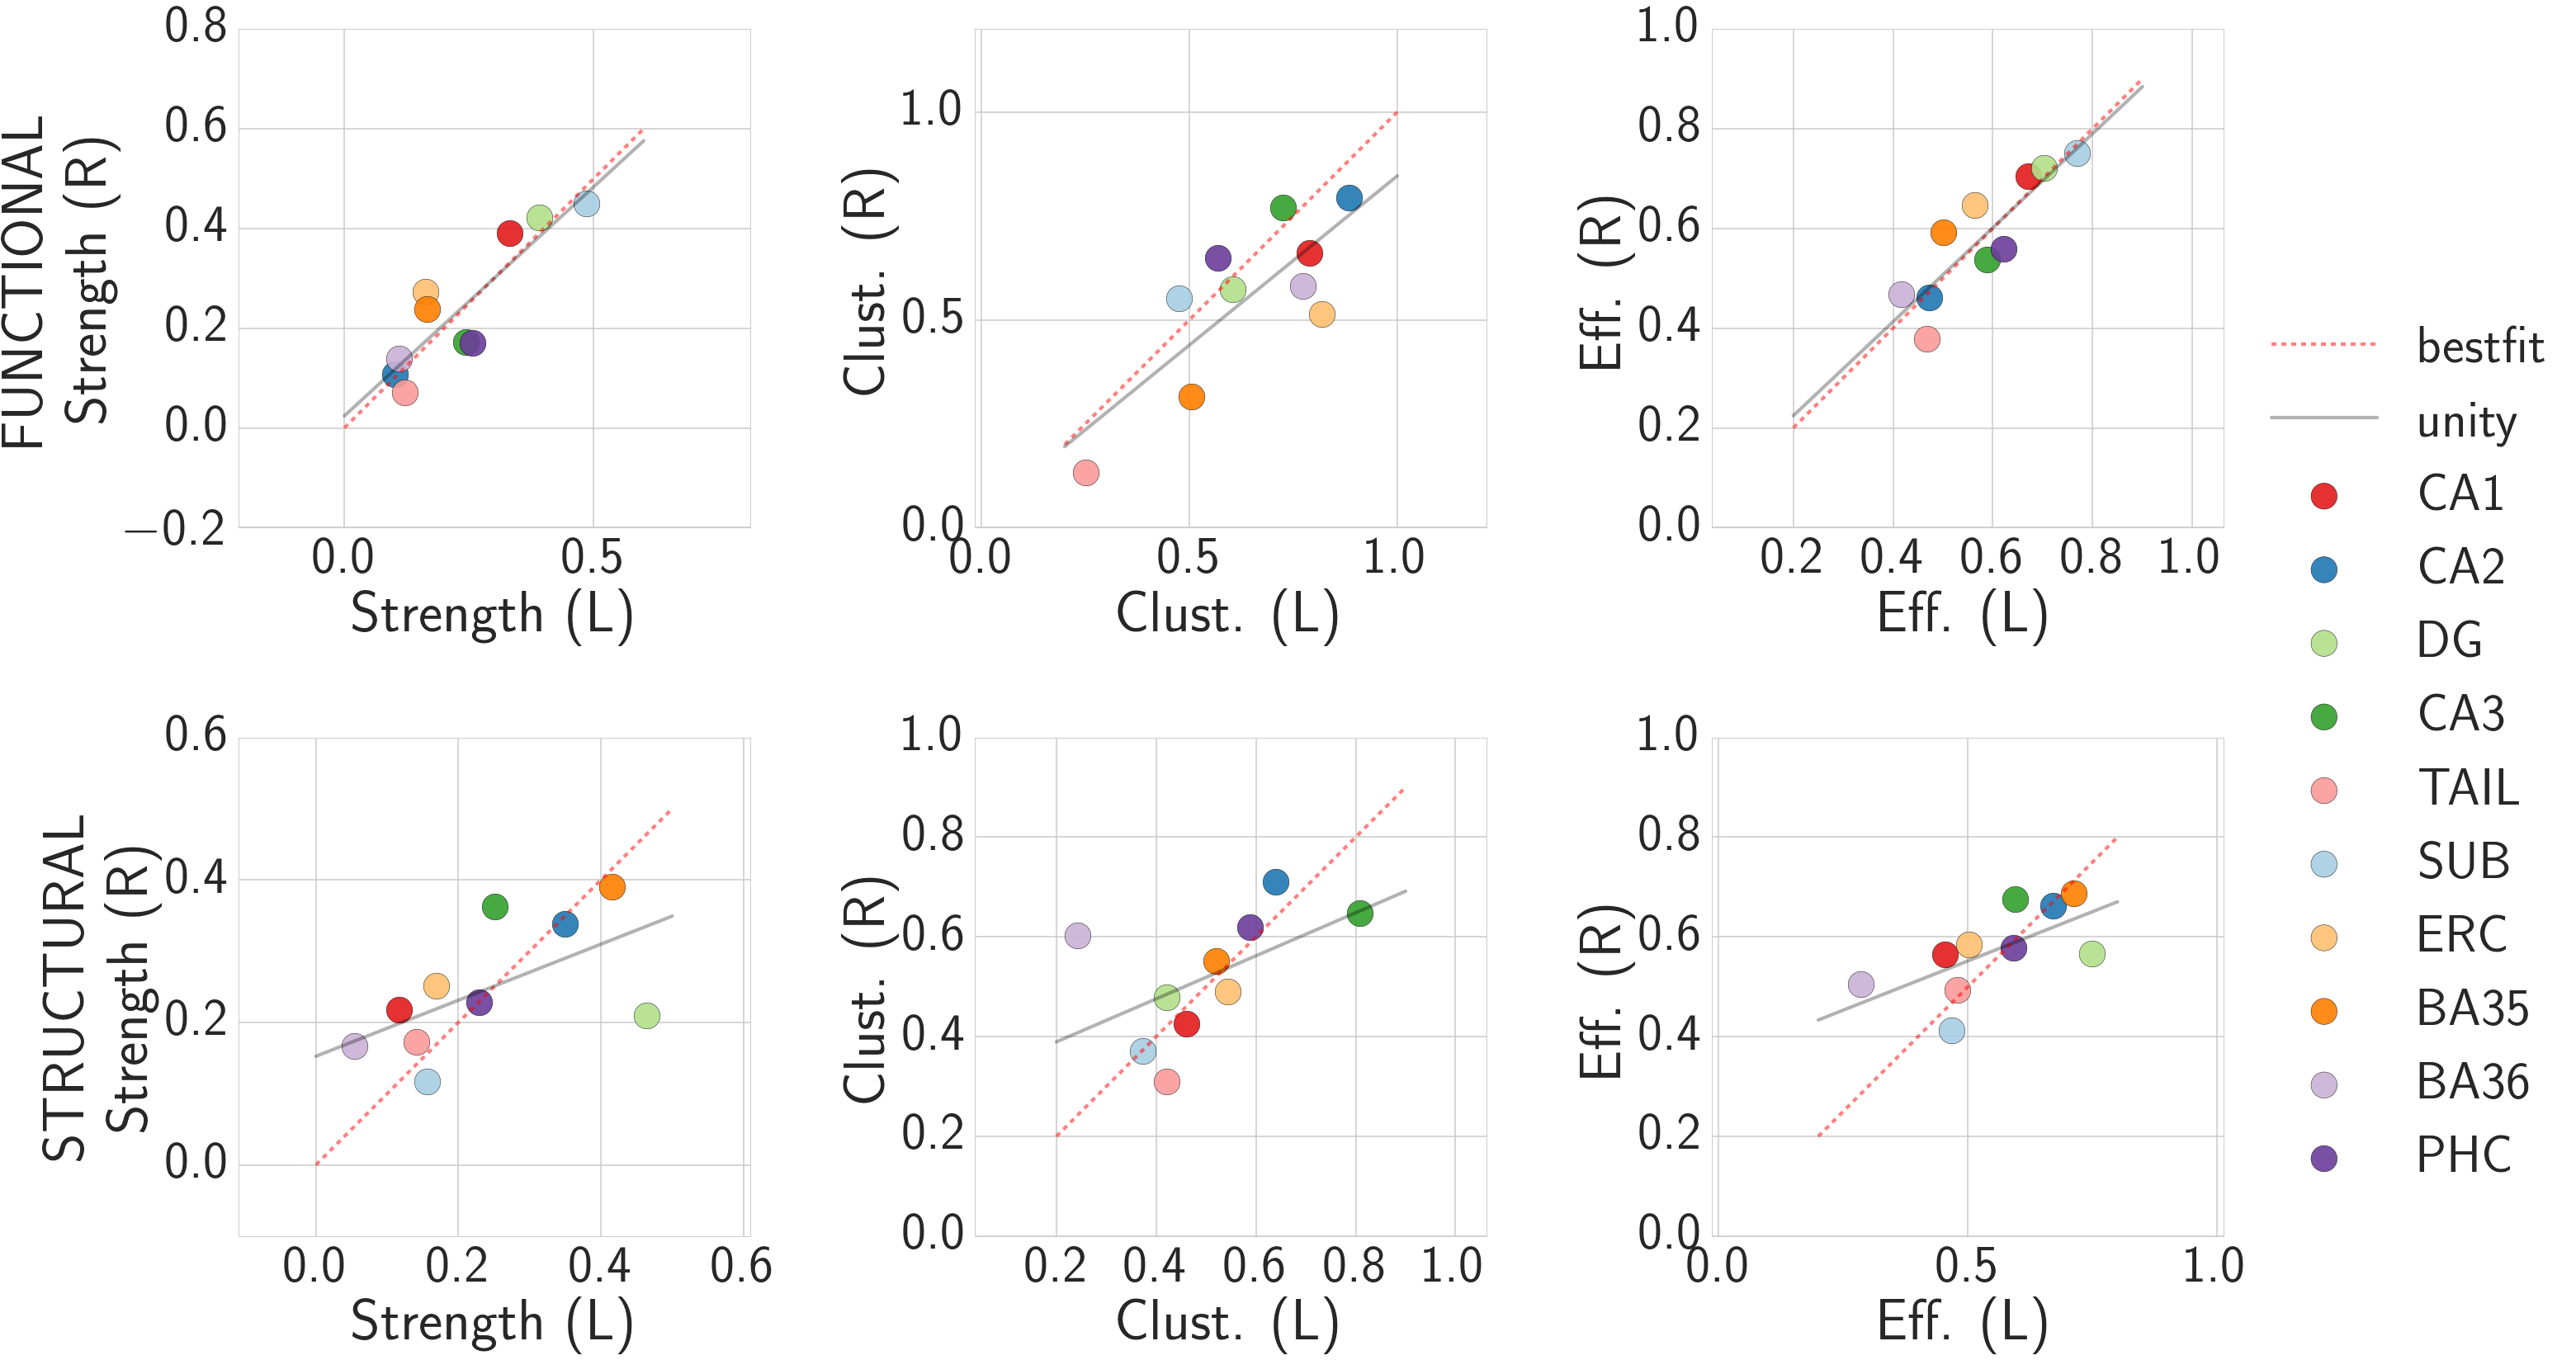

In [82]:
mycolorbrewer = ["#e31a1c","#1f78b4","#b2df8a","#33a02c","#fb9a99","#a6cee3","#fdbf6f","#ff7f00","#cab2d6","#6a3d9a"]
sb.set(context="poster", font_scale=4)
sb.set_style("whitegrid")
plt.figure(figsize=(40,25))

for i in range(2):
    for j in range(3):       
        plt.subplot(2,3, 3*i + j + 1)  
        
        colors = itertools.cycle(sb.color_palette(mycolorbrewer))
        for k in range(N):
            mycolor = next(colors)  
            plt.scatter(np.mean(local_mets[i][j][:,0:N],axis=0)[k],np.mean(local_mets[i][j][:,N:2*N],axis=0)[k],color=mycolor,
                      s=1000,alpha=0.9,edgecolors='k')      
        plt.axis('equal',adjustable='box')
        sb.regplot(np.array([0.25, 0.26]),np.array([0.25, 0.26]), marker='',ci=None,line_kws={'alpha':0.5,'color':'red', 'linestyle':'dashed'})
        sb.regplot(np.mean(local_mets[i][j][:,0:N],axis=0),np.mean(local_mets[i][j][:,N:2*N],axis=0),marker='',ci=None, line_kws={'alpha':0.3,'color':'black'})     
        
        plt.xlabel(metrics[j] + " (L)")
        if j == 0: 
            plt.ylabel(titles[i] + "\n" + metrics[j] + " (R)")
            
        else: 
            plt.ylabel(metrics[j] + " (R)")
        plt.locator_params(nbins=6) 
        if (i==0 and j==2):
            plt.legend(loc='best', bbox_to_anchor=(1, 0.5),labels=["bestfit","unity","CA1", "CA2","DG","CA3","TAIL","SUB","ERC","BA35","BA36","PHC"])
plt.tight_layout()
plt.show()

We can also compute the overall network asymmetry index , $\nu$, for both functional and structural networks:

In [21]:
# Functional Asymmetry Index
AI_CSf = asymm(np.mean(CS_localf[:,0:N],axis=0),np.mean(CS_localf[:,N:2*N],axis=0))
AI_CCf = asymm(np.mean(CC_localf[:,0:N],axis=0),np.mean(CC_localf[:,N:2*N],axis=0))
AI_LEf = asymm(np.mean(LE_localf[:,0:N],axis=0),np.mean(LE_localf[:,N:2*N],axis=0))
v_func = np.mean((abs(AI_CSf) + abs(AI_CCf) + abs(AI_LEf))/3.0)

# Structural Asymmetry Index
AI_CS = asymm(np.mean(CS_local[:,0:N],axis=0),np.mean(CS_local[:,N:2*N],axis=0))
AI_CC = asymm(np.mean(CC_local[:,0:N],axis=0),np.mean(CC_local[:,N:2*N],axis=0))
AI_LE = asymm(np.mean(LE_local[:,0:N],axis=0),np.mean(LE_local[:,N:2*N],axis=0))
v_struct = np.mean((abs(AI_CS) + abs(AI_CC) + abs(AI_LE))/3.0)

print "v_func =" + str(v_func)
print "v_struct =" + str(v_struct)

v_func =0.0841280279958
v_struct =0.119385312781


## 6.2: Community Detection / Modularity 

Here we compute the structural modular organization, with associated p value determining significance of the modular architecture. Note that the order of the modules may display slightly differently each time this is run, due to the greedy nature of the Louvain algorithm. 

To ensure consistent modular organization, we determined the consensus modules across multiple runs of the algorithm, as well as across each subject for the functional networks. That analysis was implemented using the consensus_similarity function in the Network Community Architecture Toolbox (https://github.com/nangongwubu/Python-Version-for-Network-Community-Architecture-Toobox). The discovered modules following this consensus procedure was equivalent to our original discovered modules.

STRUCTURAL MODULAR ORAGANIZATION, p=0.0


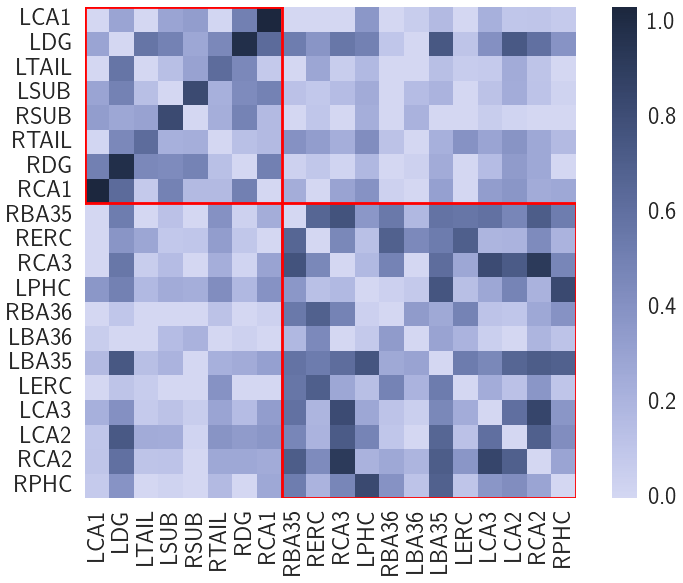

In [43]:
#show structural modules
sb.set(context="poster", font_scale=1.5)
S, Q = bct.community_louvain(structmat,1)
show_modules(structmat, S, MTlabels, mycmap)

# compute significance of structural modules using permutation testing
p = sig_mods(100, structmat, Q, 1)

print "STRUCTURAL MODULAR ORAGANIZATION, " + "p=" + str(p)   

FUNCTIONAL MODULAR ORAGANIZATION, p=0.035


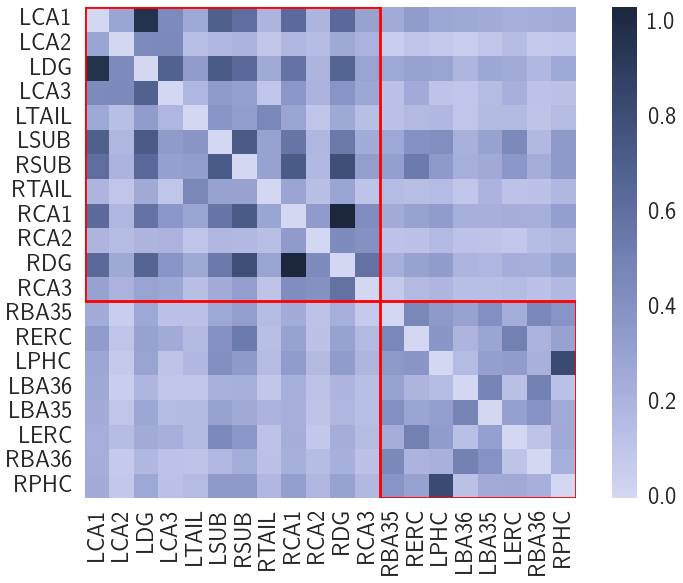

In [17]:
#show functional modules
sb.set(context="poster", font_scale=1.5)
S, Q = bct.community_louvain(funcmat,1)
show_modules(funcmat, S, MTlabels, mycmap)

# compute significance of functional modules using permutation testing
p = sig_mods(1000, funcmat, Q, 1)

print "FUNCTIONAL MODULAR ORAGANIZATION, " + "p=" + str(p)  

## 6.3 Structure-Function Relationship

Here we compute the relationship between structural and functional connectivity by correlating the edge weights in the group level structural and functional matrices:

r=0.253795135398, p=0.00043


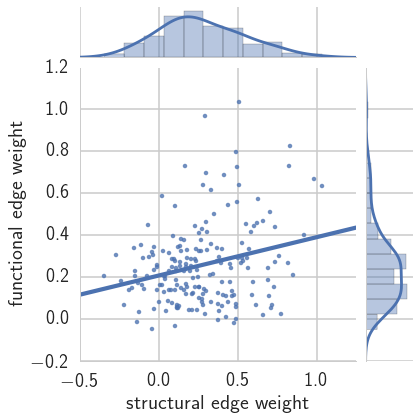

In [18]:
# generate vectors of edge strengths
struct_line = structmat_nonzeroed[np.triu_indices(2*N, 1)]
func_line = funcmats_nonzeroed_avg[np.triu_indices(2*N, 1)]

#permutation testing for significance of correlation
r = sp.stats.pearsonr(struct_line, func_line)[0]
iters = 100000
permfuncline = np.zeros((iters,190))
r_perm = np.zeros((iters,))

for i in range(iters):
    permfuncline[i,:] =  np.random.permutation(func_line)
    r_perm[i] = sp.stats.pearsonr(struct_line, permfuncline[i,:])[0]
p = (np.sum(r_perm > r) + np.sum(r_perm < -1*r)) / float(iters)

# plot results
sb.set(context="poster", font_scale=1.2)
sb.set_style("whitegrid")
g = sb.jointplot(struct_line,func_line,xlim=[-.5,1.25],ylim=[-0.2,1.2],kind="reg",stat_func=None)
g.set_axis_labels("structural edge weight", "functional edge weight")
g.ax_joint.collections[1].set_visible(False)
print "r=" + str(r) + ", p=" + str(p)

# 7. Binary Network Analysis


We believe that network structure in the MTL is better captured by weighted network analysis, but many prior network analysis studies utilize binary networks. Therefore, we have provided analagous analyses for binary networks, thresholding to achieve a range of network densities from 1% to 50%. Our analysis is shown below, though the below code can be modified for your own set of density ranges, network metrics, etc.:



##  7.1 Generate binary networks and local network metrics

In [19]:
#density range
ds= [0.01,0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
ds_len = len(ds)

CS_local, CS_localf, CC_local, CC_localf, LE_local, LE_localf = np.zeros((nboots,2*N,ds_len)),np.zeros((nboots,2*N,ds_len)),np.zeros((nboots,2*N,ds_len)),np.zeros((nboots,2*N,ds_len)),np.zeros((nboots,2*N,ds_len)),np.zeros((nboots,2*N,ds_len))
CS_local_rand, CS_local_randf, CC_local_rand, CC_local_randf,LE_local_rand, LE_local_randf = np.zeros((nboots,2*N,ds_len)),np.zeros((nboots,2*N,ds_len)),np.zeros((nboots,2*N,ds_len)),np.zeros((nboots,2*N,ds_len)),np.zeros((nboots,2*N,ds_len)),np.zeros((nboots,2*N,ds_len))

boot_structmats_bin = np.zeros((2*N,2*N,nboots,ds_len))
boot_funcmats_bin = np.zeros((2*N,2*N,nboots,ds_len))
for  idx, d in enumerate(ds): 
    # Structural Network Analyses
    boot_structmats_bin[:,:,:,idx] = binarize_mats(boot_structmats,d)
    CS_local[:,:,idx],CS_local_rand[:,:,idx] = boot_metrics_bin(boot_structmats_bin[:,:,:,idx], "CS")
    CC_local[:,:,idx],CC_local_rand[:,:,idx] = boot_metrics_bin(boot_structmats_bin[:,:,:,idx], "CC")
    LE_local[:,:,idx],LE_local_rand[:,:,idx] = boot_metrics_bin(boot_structmats_bin[:,:,:,idx], "LE")

    # Functional Network Analyses
    boot_funcmats_bin[:,:,:,idx] = binarize_mats(boot_funcmats,d)
    CS_localf[:,:,idx],CS_local_randf[:,:,idx] = boot_metrics_bin(boot_funcmats_bin[:,:,:,idx], "CS")
    CC_localf[:,:,idx],CC_local_randf[:,:,idx] = boot_metrics_bin(boot_funcmats_bin[:,:,:,idx], "CC")
    LE_localf[:,:,idx],LE_local_randf[:,:,idx] = boot_metrics_bin(boot_funcmats_bin[:,:,:,idx], "LE")

## 7.2 Structural and Functional Network Asymmetry and Hubness Visualization

### 7.2.1 Analysis at fixed density

Here we'll demonstrate asymmetry and hubness analysis for our network at a sample density of 25%:

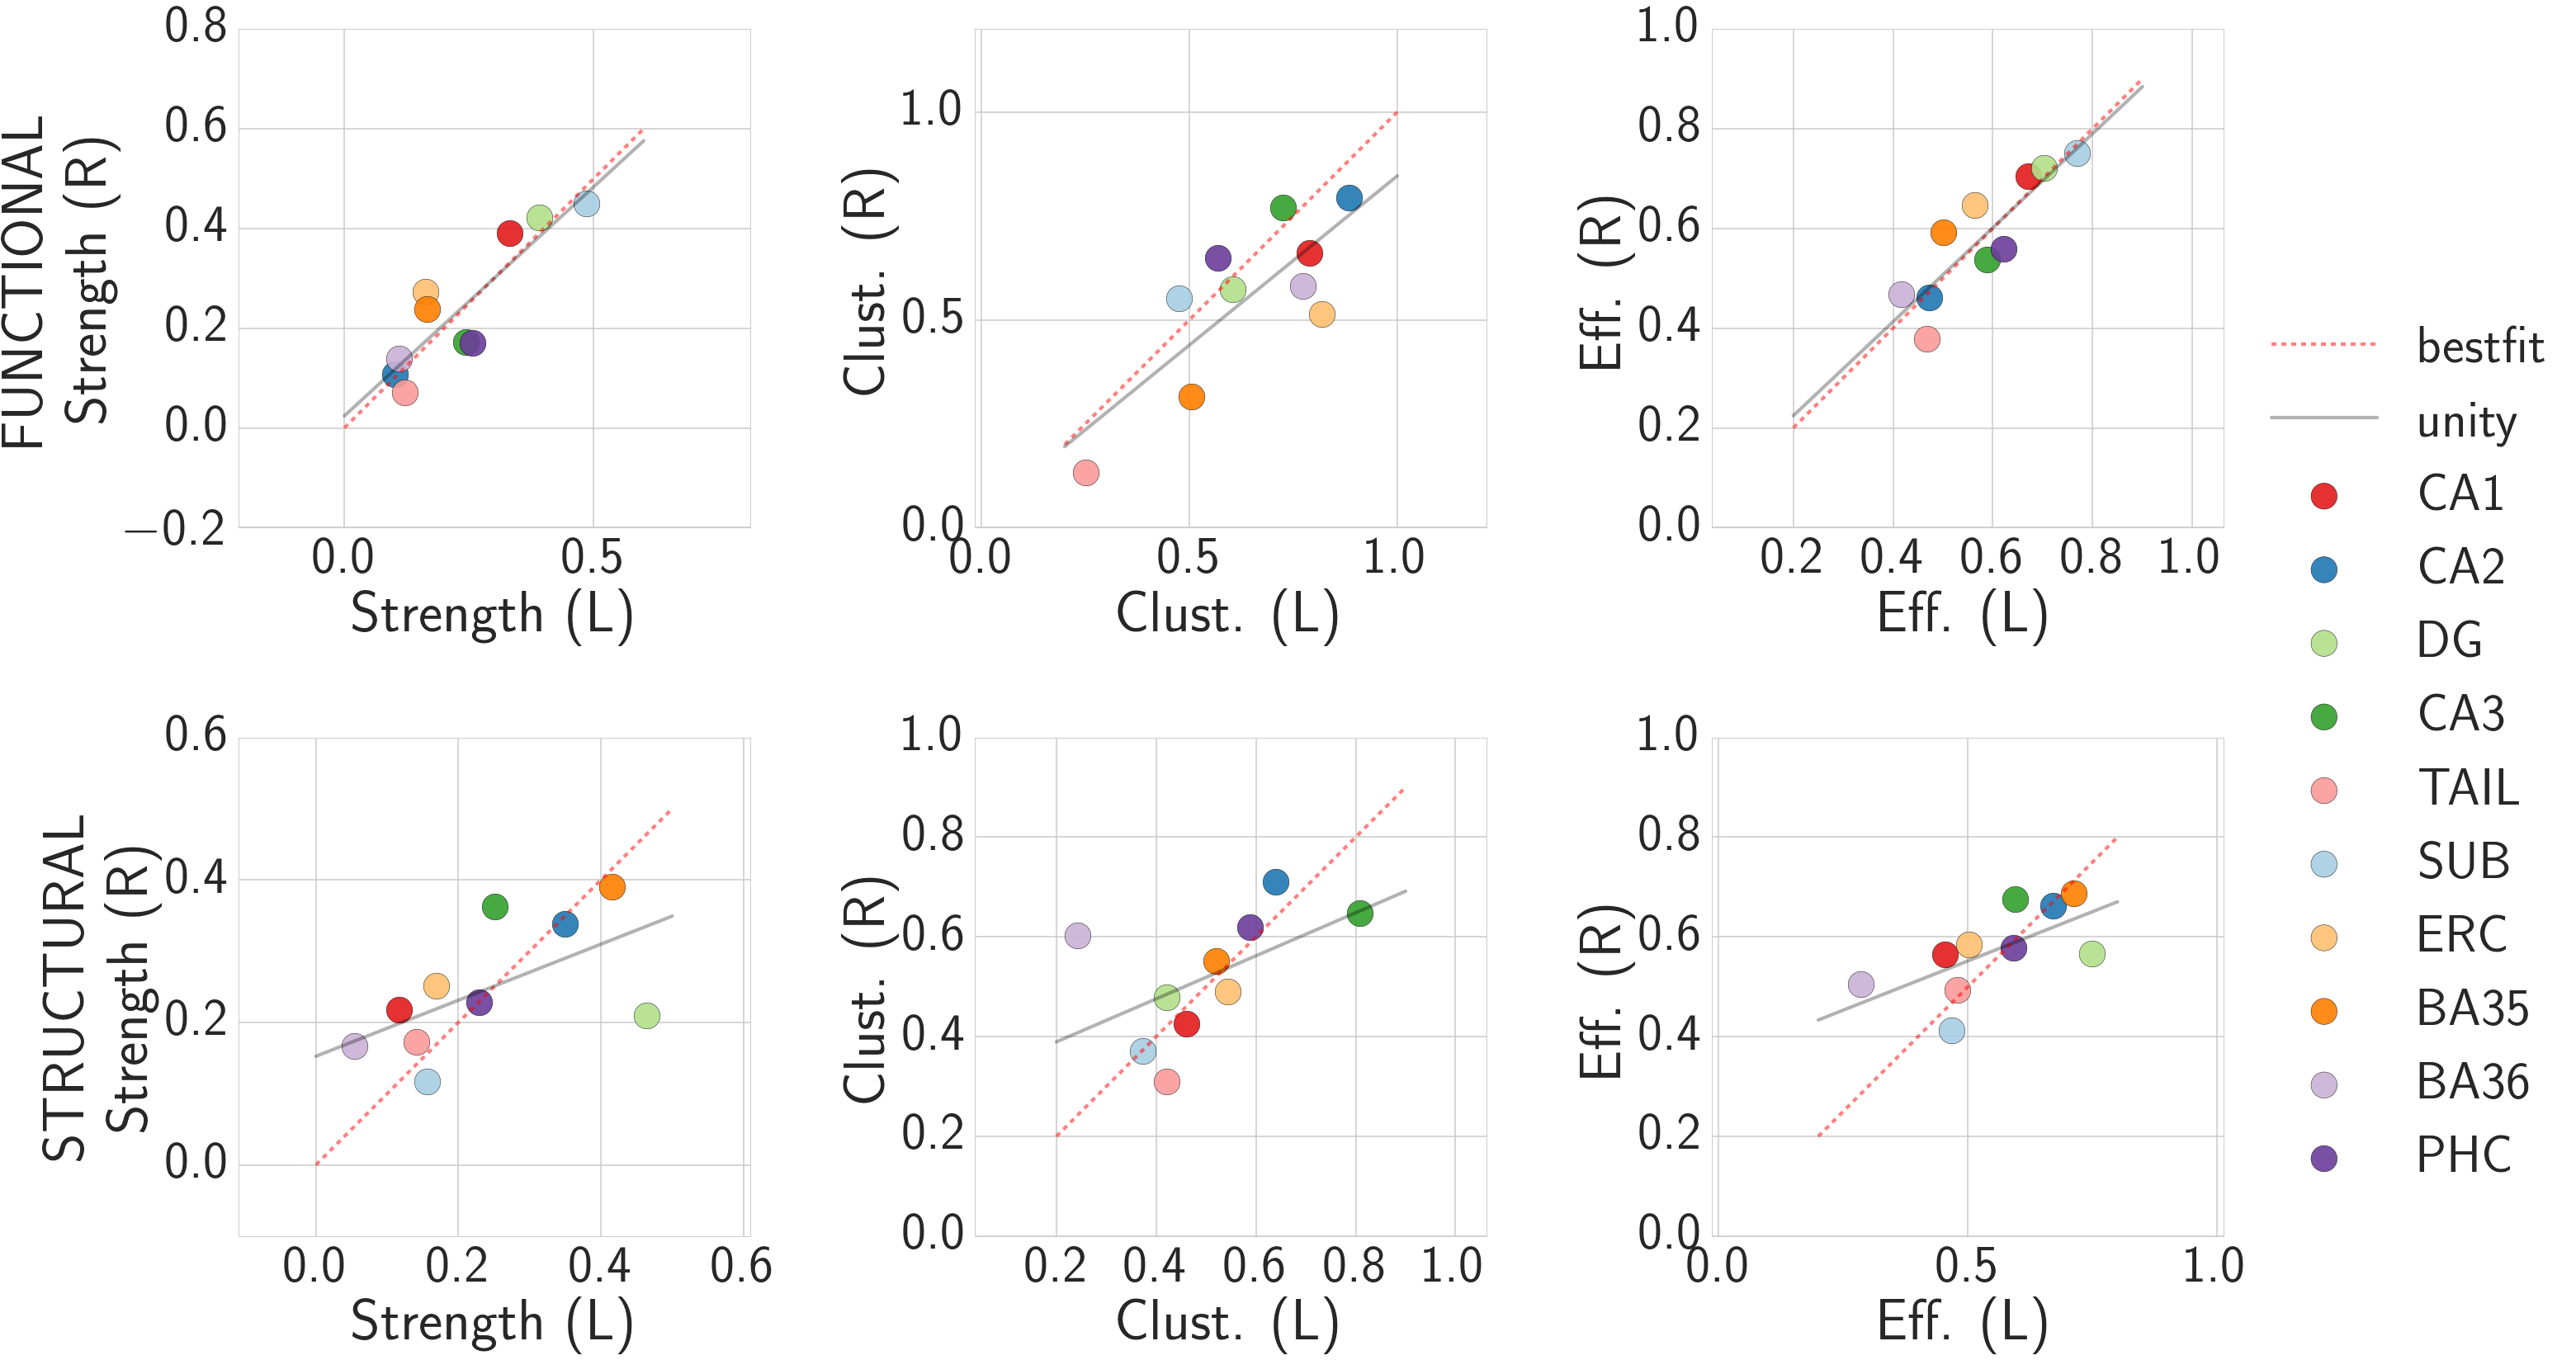

In [81]:
d=0.25 # for ds 
d_idx = ds.index(d)

local_mets = [[CS_localf[:,:,d_idx],CC_localf[:,:,d_idx], LE_localf[:,:,d_idx]],[CS_local[:,:,d_idx],CC_local[:,:,d_idx], LE_local[:,:,d_idx]]]
titles = ["FUNCTIONAL","STRUCTURAL"]
metrics = ["Strength","Clust.","Eff."]

mycolorbrewer = ["#e31a1c","#1f78b4","#b2df8a","#33a02c","#fb9a99","#a6cee3","#fdbf6f","#ff7f00","#cab2d6","#6a3d9a"]
sb.set(context="poster", font_scale=4)
sb.set_style("whitegrid")
plt.figure(figsize=(40,25))

for i in range(2):
    for j in range(3):       
        plt.subplot(2,3, 3*i + j + 1)  
        
        colors = itertools.cycle(sb.color_palette(mycolorbrewer))
        for k in range(N):
            mycolor = next(colors)  
            plt.scatter(np.mean(local_mets[i][j][:,0:N],axis=0)[k],np.mean(local_mets[i][j][:,N:2*N],axis=0)[k],color=mycolor,
                      s=1000,alpha=0.9,edgecolors='k')      
        plt.axis('equal',adjustable='box')
        sb.regplot(np.array([0.25, 0.26]),np.array([0.25, 0.26]), marker='',ci=None,line_kws={'alpha':0.5,'color':'red', 'linestyle':'dashed'})
        sb.regplot(np.mean(local_mets[i][j][:,0:N],axis=0),np.mean(local_mets[i][j][:,N:2*N],axis=0),marker='',ci=None, line_kws={'alpha':0.3,'color':'black'})     
        
        plt.xlabel(metrics[j] + " (L)")
        if j == 0: 
            plt.ylabel(titles[i] + "\n" + metrics[j] + " (R)")
            
        else: 
            plt.ylabel(metrics[j] + " (R)")
        plt.locator_params(nbins=6) 
        if (i==0 and j==2):
            plt.legend(loc='best', bbox_to_anchor=(1, 0.5),labels=["bestfit","unity","CA1", "CA2","DG","CA3","TAIL","SUB","ERC","BA35","BA36","PHC"])
plt.tight_layout()
plt.show()

In [34]:
# Functional Asymmetry Index
AI_CSf = asymm(np.mean(CS_localf[:,0:N],axis=0),np.mean(CS_localf[:,N:2*N],axis=0))
AI_CCf = asymm(np.mean(CC_localf[:,0:N],axis=0),np.mean(CC_localf[:,N:2*N],axis=0))
AI_LEf = asymm(np.mean(LE_localf[:,0:N],axis=0),np.mean(LE_localf[:,N:2*N],axis=0))
v_func = np.mean((abs(AI_CSf) + abs(AI_CCf) + abs(AI_LEf))/3.0)

# Structural Asymmetry Index
AI_CS = asymm(np.mean(CS_local[:,0:N],axis=0),np.mean(CS_local[:,N:2*N],axis=0))
AI_CC = asymm(np.mean(CC_local[:,0:N],axis=0),np.mean(CC_local[:,N:2*N],axis=0))
AI_LE = asymm(np.mean(LE_local[:,0:N],axis=0),np.mean(LE_local[:,N:2*N],axis=0))
v_struct = np.mean((abs(AI_CS) + abs(AI_CC) + abs(AI_LE))/3.0)

print "v_func =" + str(v_func)
print "v_struct =" + str(v_struct)

v_func =0.0841280279958
v_struct =0.119385312781


### 7.2.2 Analysis over a range of densities

It would be useful to visualize asymmetry across the entire range of densities, rather than choosing one arbitrary threshold. We can carry out that analysis below: 

In [36]:
CS_AIf = np.zeros((nboots,N,ds_len))
CC_AIf = np.zeros((nboots,N,ds_len))
LE_AIf = np.zeros((nboots,N,ds_len))

CS_AIf_rand = np.zeros((nboots,N,ds_len))
CC_AIf_rand = np.zeros((nboots,N,ds_len))
LE_AIf_rand = np.zeros((nboots,N,ds_len))


for i in range(N): 
    CS_AIf[:,i,:] = asymm(CS_localf[:,i,:], CS_localf[:,i+N,:])
    CC_AIf[:,i,:] = asymm(CC_localf[:,i,:], CC_localf[:,i+N,:])
    LE_AIf[:,i,:] = asymm(LE_localf[:,i,:], LE_localf[:,i+N,:])
    
    CS_AIf_rand[:,i,:] = asymm(CS_local_randf[:,i,:], CS_local_randf[:,i+N,:])
    CC_AIf_rand[:,i,:] = asymm(CC_local_randf[:,i,:], CC_local_randf[:,i+N,:])
    LE_AIf_rand[:,i,:] = asymm(LE_local_randf[:,i,:], LE_local_randf[:,i+N,:])

AIf = np.mean((abs(CS_AIf) + abs(CC_AIf) + abs(LE_AIf))/3.0,axis=1)
AIf_rand = np.mean((abs(CS_AIf_rand) + abs(CC_AIf_rand) + abs(LE_AIf_rand))/3.0,axis=1)

In [37]:
CS_AI = np.zeros((nboots,N,ds_len))
CC_AI = np.zeros((nboots,N,ds_len))
LE_AI = np.zeros((nboots,N,ds_len))

CS_AI_rand = np.zeros((nboots,N,ds_len))
CC_AI_rand = np.zeros((nboots,N,ds_len))
LE_AI_rand = np.zeros((nboots,N,ds_len))

for i in range(N): 
    CS_AI[:,i,:] = asymm(CS_local[:,i,:], CS_local[:,i+N,:])
    CC_AI[:,i,:] = asymm(CC_local[:,i,:], CC_local[:,i+N,:])
    LE_AI[:,i,:] = asymm(LE_local[:,i,:], LE_local[:,i+N,:])
    
    CS_AI_rand[:,i,:] = asymm(CS_local_rand[:,i,:], CS_local_rand[:,i+N,:])
    CC_AI_rand[:,i,:] = asymm(CC_local_rand[:,i,:], CC_local_rand[:,i+N,:])
    LE_AI_rand[:,i,:] = asymm(LE_local_rand[:,i,:], LE_local_rand[:,i+N,:])
    
AI = np.mean((abs(CS_AI) + abs(CC_AI) + abs(LE_AI))/3.0,axis=1)
AI_rand = np.mean((abs(CS_AI_rand) + abs(CC_AI_rand) + abs(LE_AI_rand))/3.0,axis=1)

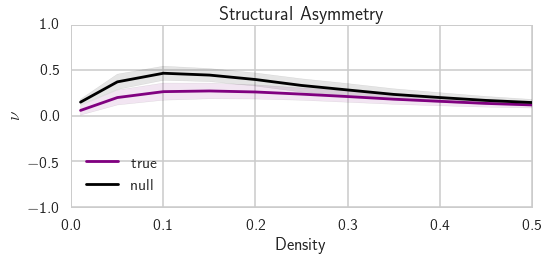

In [31]:
sb.set(context="poster", font_scale=1)
sb.set_style("whitegrid")
plt.figure(figsize=(8,4))
ax = plt.axes()
plt.ylim([-1,1])
plt.plot(ds,np.mean(AI,axis=0),color="purple")
plt.fill_between(ds, np.mean(AI,axis=0) -np.std(AI,axis=0), np.mean(AI,axis=0)+np.std(AI,axis=0), facecolor='purple', alpha = 0.1)

plt.plot(ds,np.mean(AI_rand,axis=0),color="black")
plt.fill_between(ds, np.mean(AI_rand,axis=0) -np.std(AI_rand,axis=0), np.mean(AI_rand,axis=0)+np.std(AI_rand,axis=0), facecolor='k', alpha = 0.1)
plt.title('Structural Asymmetry')
plt.ylabel(r'$\nu$')
plt.xlabel('Density')
plt.legend(["true","null"],loc="lower left")
plt.tight_layout()

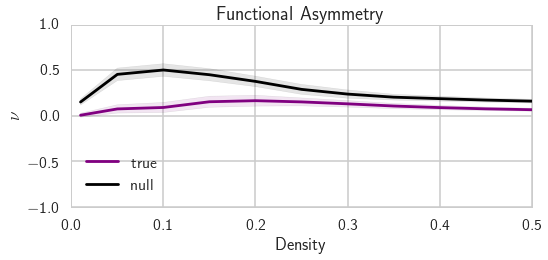

In [40]:
sb.set(context="poster", font_scale=1)
sb.set_style("whitegrid")
plt.figure(figsize=(8,4))
ax = plt.axes()
plt.ylim([-1,1])
plt.plot(ds,np.mean(AIf,axis=0),color="purple")
plt.fill_between(ds, np.mean(AIf,axis=0) -np.std(AIf,axis=0), np.mean(AIf,axis=0)+np.std(AIf,axis=0), facecolor='purple', alpha = 0.1)

plt.plot(ds,np.mean(AIf_rand,axis=0),"k-")
plt.fill_between(ds, np.mean(AIf_rand,axis=0) - np.std(AIf_rand,axis=0), np.mean(AIf_rand,axis=0)+np.std(AIf_rand,axis=0), facecolor='k', alpha = 0.1)
plt.title('Functional Asymmetry')
plt.ylabel(r'$\nu$')
plt.xlabel('Density')
plt.legend(["true","null"],loc="lower left")
plt.tight_layout()

## 7.3 Modularity Analysis

We can carry out modularity analysis for any density threshold. Note that community detection may not be as robust as in the weighted networks since we lose considerable information by thresholding and including only binary values in the network. Therefore, there may be more variability in the chosen modules each time the algorithm is run. Below is an example of modularity analysis for the functional network, with a threshold of 25%:

FUNCTIONAL MODULAR ORAGANIZATION, p=0.0


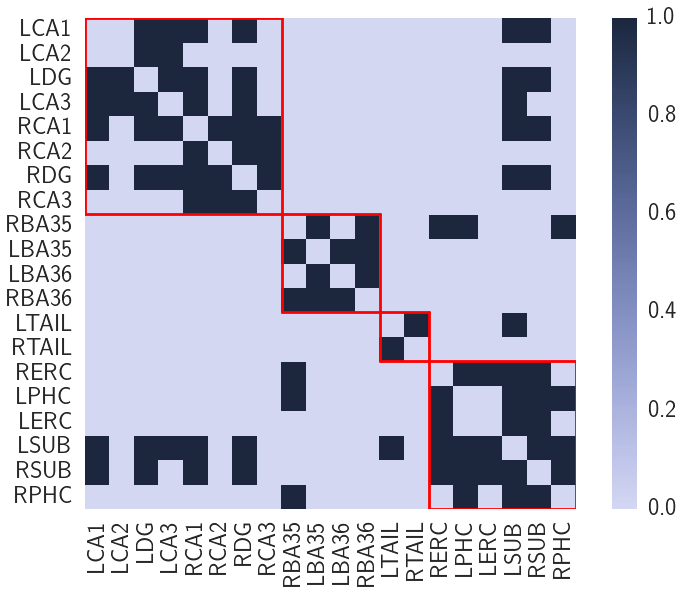

In [45]:
#show functional modules
sb.set(context="poster", font_scale=1.5)
funcmat_bin= bct.binarize(bct.threshold_proportional(funcmat, d, copy=True), copy=True)

S, Q = bct.community_louvain(funcmat_bin,1)
show_modules(funcmat_bin, S, MTlabels, mycmap)

# compute significance of functional modules using permutation testing
p = sig_mods(10, funcmat_bin, Q, 1)

print "FUNCTIONAL MODULAR ORAGANIZATION, " + "p=" + str(p)

## 7.4 Structure-Function Relationship

In order to quantify the relationship between structural and functional connectivity, we can compute the Dice Similar Coefficient, which is the fractional overlap between two matrices. We compare this to a null distribution of overlaps to assess the significance of the overlap across a range of densities:

In [78]:
# generate vectors of edge strengths

DSCs = np.zeros((len(ds),nboots))
DSCs_rand = np.zeros((len(ds),nboots))
for  idx, d in enumerate(ds):
    for boot in range(nboots):
        funcmat_bin= boot_funcmats_bin[:,:,boot,idx]
        funcmat_bin_rand = null_rand(funcmat_bin)
        structmat_bin= boot_structmats_bin[:,:,boot,idx]
        structmat_bin_rand = null_rand(structmat_bin)
        DSCs[idx, boot] = dice(funcmat_bin, structmat_bin)
        DSCs_rand[idx, boot] = dice(funcmat_bin_rand, structmat_bin_rand)

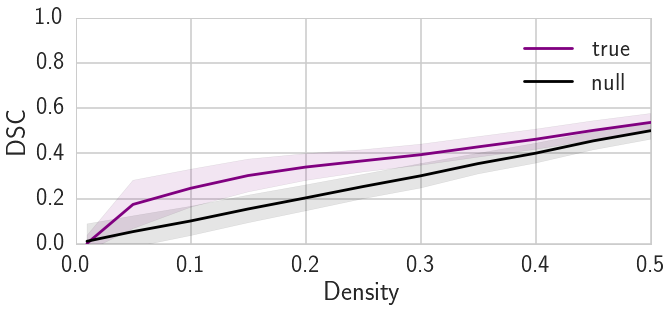

In [79]:
sb.set(context="poster", font_scale=1.5)
sb.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.ylim([0,1])
plt.plot(ds,np.mean(DSCs,axis=1),color="purple")
plt.fill_between(ds, np.mean(DSCs,axis=1) -np.std(DSCs,axis=1), np.mean(DSCs,axis=1)+np.std(DSCs,axis=1), facecolor='purple', alpha = 0.1)

plt.plot(ds,np.mean(DSCs_rand,axis=1),"k-")
plt.fill_between(ds, np.mean(DSCs_rand,axis=1) -np.std(DSCs_rand,axis=1), np.mean(DSCs_rand,axis=1)+np.std(DSCs_rand,axis=1), facecolor='k', alpha = 0.1)
plt.legend(["true","null"],loc="best")
plt.xlabel('Density')
plt.ylabel('DSC')
plt.tight_layout()

Here we compute the p values for significance of overlap:

In [80]:
for  idx, d in enumerate(ds):
    p = np.sum(DSCs_rand[idx,:] > np.mean(DSCs[idx,:])) / float(nboots)
    print "Density = " + str(d) + ": " +str(p)

Density = 0.01: 0.024
Density = 0.05: 0.086
Density = 0.1: 0.024
Density = 0.15: 0.017
Density = 0.2: 0.012
Density = 0.25: 0.013
Density = 0.3: 0.042
Density = 0.35: 0.064
Density = 0.4: 0.065
Density = 0.45: 0.104
Density = 0.5: 0.15


....And we're done!